In [1]:
# Uncomment only if you want to reprocess the raw data using initial_prep.py
# The script will re-create crashes.gz, comma separated gzipped file in ../data/processed

## %run ../src/preprocessing/initial_prep.py

In [2]:
%run ../src/import_libraries.py

%matplotlib inline

In [3]:
# Loading data:

full_df=pd.read_csv('../data/processed/crashes.gz', compression='gzip', low_memory=False)


In [4]:
sample_df=full_df.sample(100000, random_state=100).copy()
#sample_df=full_df.copy()

y = sample_df['GUILTY']
x = sample_df.drop(['GUILTY'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=100, stratify=y)


In [5]:
numeric_columns = ['NUM_PASSENGERS','AGE']

nominal_columns = ['DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','VEHICLE_DEFECT', 'ROAD_DEFECT',
             'DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 'VEHICLE_AGE', 'AIRBAG_DEPLOYED',
            'PHYSICAL_CONDITION', 'MANEUVER',  'DRIVER_VISION',  'ALIGNMENT' ,  'TRAFFIC_CONTROL_DEVICE',
                    'VEHICLE_YEAR', 'SAFETY_EQUIPMENT','WEATHER_CONDITION','LIGHTING_CONDITION',
                     'VEHICLE_TYPE']



# Defining Pipeline

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_columns)),
        ('imputer', SimpleImputer(strategy = 'constant', fill_value=0))
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(nominal_columns)),
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
    ])


fu = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


X_train_transformed = fu.fit_transform(X_train)
#X_train.info(verbose=True, show_counts=True)


# Logistic Regression Model

In [7]:

baseline_pipe = Pipeline([ ('fu', fu),
                          ('standardscale', StandardScaler()),
                          ('model',LogisticRegression(max_iter = 10000, solver = 'newton-cg'))])
baseline_pipe.fit(X_train, y_train)

y_pred_test = baseline_pipe.predict(X_test)
y_pred_train = baseline_pipe.predict(X_train)


In [8]:
print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))
y_hat_train_prob = baseline_pipe.decision_function(X_train)
train_roc = roc_auc_score(y_train, y_hat_train_prob)

y_hat_test_prob = baseline_pipe.decision_function(X_test)
test_roc = roc_auc_score(y_test, y_hat_test_prob)

print(f"Test:{test_roc}, Train:{train_roc}")


              precision    recall  f1-score   support

           0       0.82      0.87      0.84     48373
           1       0.73      0.65      0.69     26627

    accuracy                           0.79     75000
   macro avg       0.78      0.76      0.77     75000
weighted avg       0.79      0.79      0.79     75000

------------
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     16124
           1       0.73      0.65      0.69      8876

    accuracy                           0.79     25000
   macro avg       0.78      0.76      0.77     25000
weighted avg       0.79      0.79      0.79     25000

Test:0.8426264268223655, Train:0.84556724976334


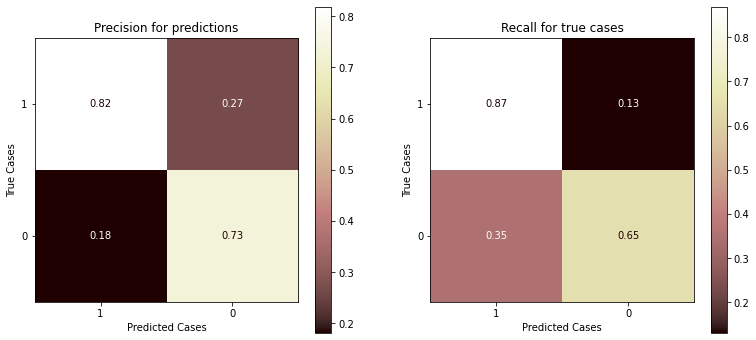

In [16]:
fig, ax = plt.subplots(figsize=(13,6), ncols=2)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='pred', 
                                        display_labels=[1,0],cmap='pink', ax=ax[0])


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true', 
                                        display_labels=[1,0],cmap='pink', ax=ax[1]);

ax[0].set_title("Precision for predictions")
ax[1].set_title("Recall for true cases")

ax[0].set_xlabel('Predicted Cases')
ax[0].set_ylabel('True Cases')
ax[1].set_xlabel('Predicted Cases')
ax[1].set_ylabel('True Cases');

# Logistic Regression with GridSearch

In [9]:
#pipe_grid = {'model__solver': ['newton-cg','lbfgs']}
pipe_grid = {'model__solver': ['newton-cg']}
gs_pipe = GridSearchCV(estimator=baseline_pipe, param_grid=pipe_grid, cv=10)


In [10]:
gs_pipe.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('fu',
                                        FeatureUnion(transformer_list=[('num_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['NUM_PASSENGERS',
                                                                                                                            'AGE'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value=0,
                                                                                                       strategy='constant'))])),
                                                                       ('cat_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['DEVICE_CONDITION',
                                                                                                                            'F...
                                                                                                                            'DRIVER_VISION',
                                                                                                                            'ALIGNMENT',
                                                                                                                            'TRAFFIC_CONTROL_DEVICE',
                                                                                                                            'VEHICLE_YEAR',
                                                                                                                            'SAFETY_EQUIPMENT',
                                                                                                                            'WEATHER_CONDITION',
                                                                                                                            'LIGHTING_CONDITION',
                                                                                                                            'VEHICLE_TYPE'])),
                                                                                        ('cat_encoder',
                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                       sparse=False))]))])),
                                       ('standardscale', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           solver='newton-cg'))]),
             param_grid={'model__solver': ['newton-cg']})

In [11]:
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

In [12]:
y_hat_train_prob = gs_pipe.decision_function(X_train)
train_roc = roc_auc_score(y_train, y_hat_train_prob)

y_hat_test_prob = gs_pipe.decision_function(X_test)
test_roc = roc_auc_score(y_test, y_hat_test_prob)

print(f"Test:{test_roc}, Train:{train_roc}")

Test:0.8426264268223655, Train:0.84556724976334


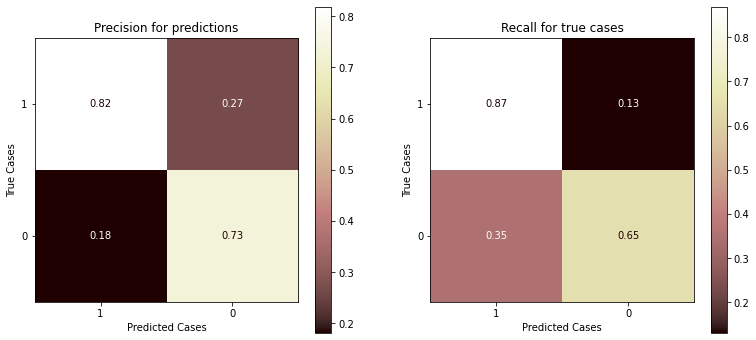

In [13]:
fig, ax = plt.subplots(figsize=(13,6), ncols=2)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='pred', 
                                        display_labels=[1,0],cmap='pink', ax=ax[0])


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true', 
                                        display_labels=[1,0],cmap='pink', ax=ax[1]);

ax[0].set_title("Precision for predictions")
ax[1].set_title("Recall for true cases")

ax[0].set_xlabel('Predicted Cases')
ax[0].set_ylabel('True Cases')
ax[1].set_xlabel('Predicted Cases')
ax[1].set_ylabel('True Cases');

# Decision Tree model (tuning max_depth)


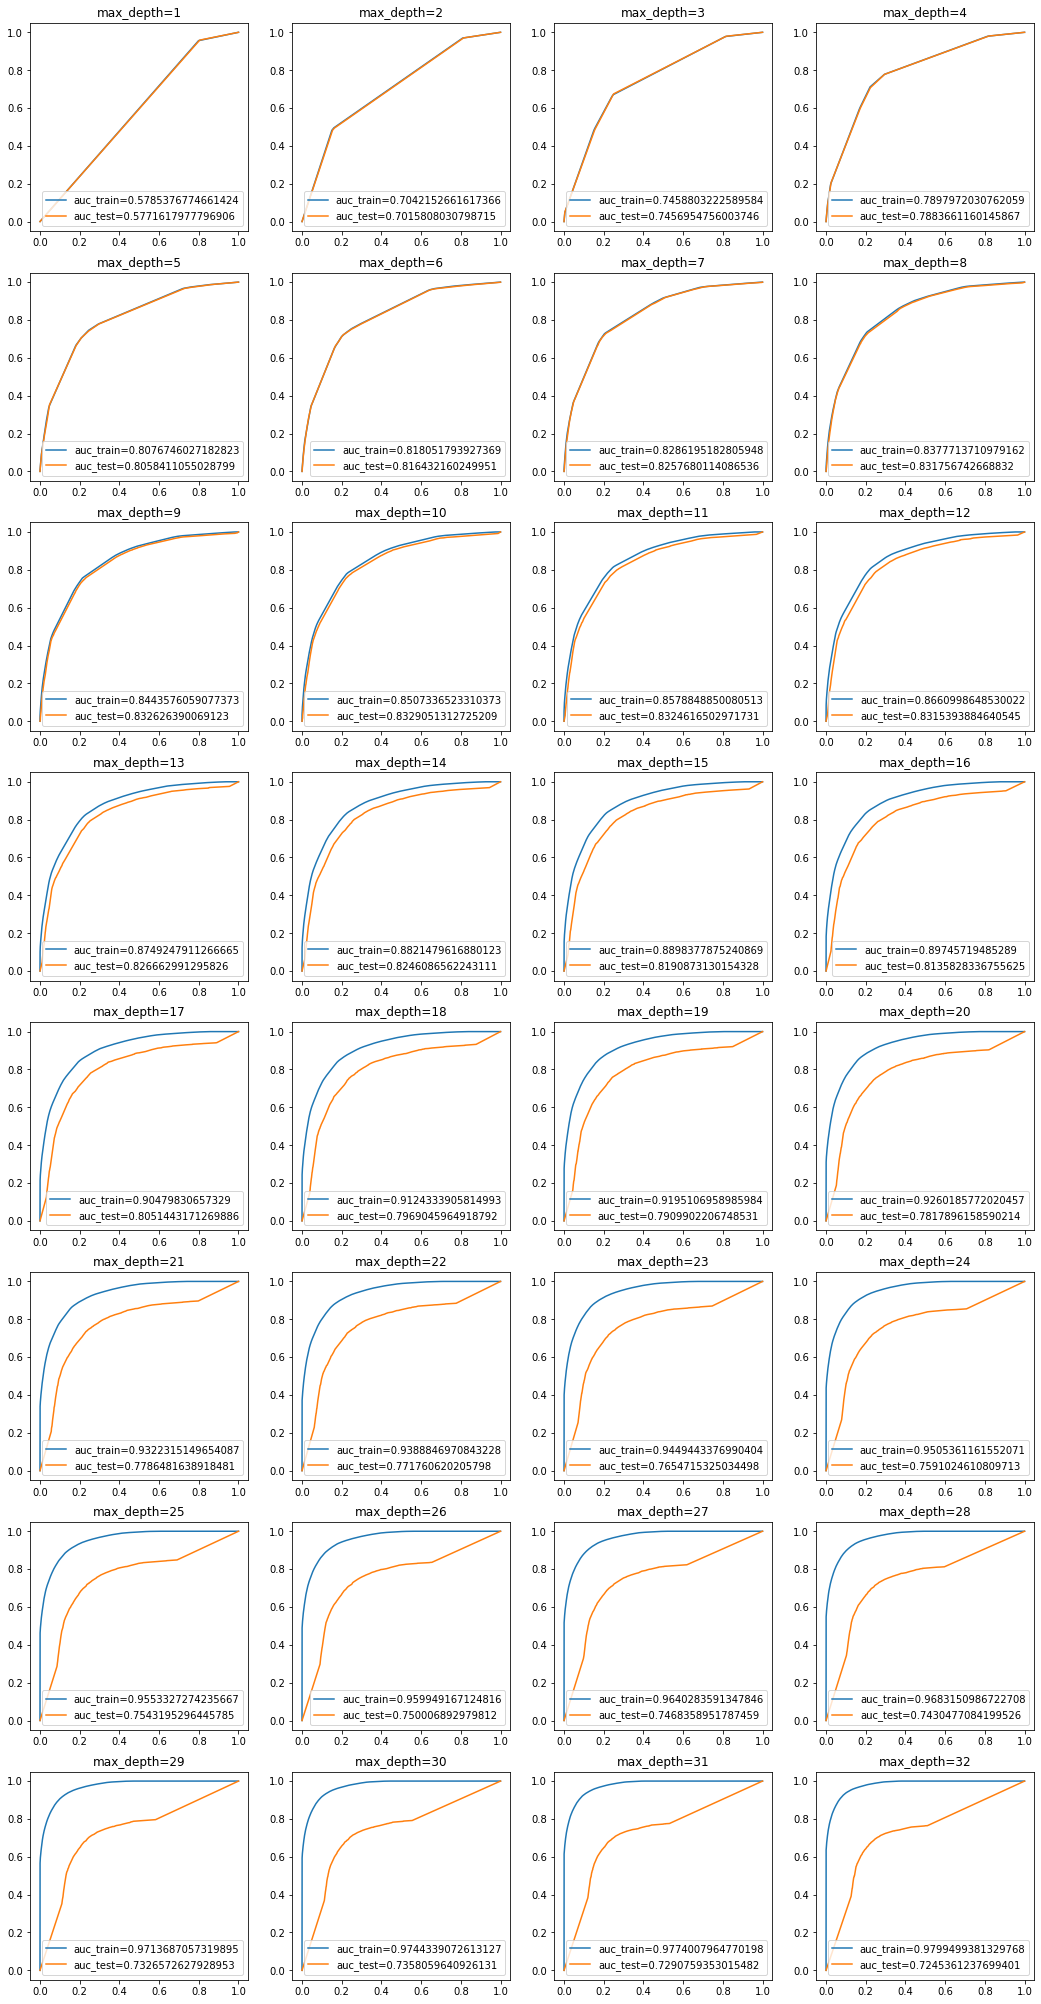

In [14]:
y_hat_train_prob = gs_pipe.decision_function(X_train)
y_score = roc_auc_score(y_train, y_hat_train_prob)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_hat_train_prob)
y_score

max_depth=np.arange(0,32)
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(18,36))
for i in max_depth:
    # Train the classifier using training data
    
    dt = Pipeline([('fu', fu),
                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
                          ('model',DecisionTreeClassifier(criterion='entropy', random_state=100,max_depth=i+1))
                              ])
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    # Check the AUC of predictions
    fpr_test, tpr_test, thresholds = roc_curve(y_test, dt.predict_proba(X_test)[:,1])
    roc_auc_test = auc(fpr_test, tpr_test)
    
    fpr_train, tpr_train, thresholds = roc_curve(y_train, dt.predict_proba(X_train)[:,1])
    roc_auc_train = auc(fpr_train, tpr_train)
    
    row = i//4
    col = i%4
    ax = axes[row, col]
    ax.plot(fpr_train, tpr_train, label=f'auc_train={roc_auc_train}')
    ax.plot(fpr_test, tpr_test, label=f'auc_test={roc_auc_test}')
    ax.set_title(f'max_depth={i+1}')
    ax.legend(loc='lower right')

# Random Forest Model

In [18]:
baseline_tree_pipe = Pipeline([('fu', fu),
                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
                          ('model', RandomForestClassifier( n_estimators=150, min_samples_leaf=15)),

 
                              ])
baseline_tree_pipe.fit(X_train, y_train)
y_pred_test = baseline_tree_pipe.predict(X_test)
y_pred_train = baseline_tree_pipe.predict(X_train)

print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))

y_hat_train_prob = gs_pipe.predict_proba(X_train)[:,1]
train_roc = roc_auc_score(y_train, y_hat_train_prob)

y_hat_test_prob = gs_pipe.predict_proba(X_test)[:,1]
test_roc = roc_auc_score(y_test, y_hat_test_prob)

print(f"Test:{test_roc}, Train:{train_roc}")




              precision    recall  f1-score   support

           0       0.82      0.89      0.85     48373
           1       0.77      0.63      0.69     26627

    accuracy                           0.80     75000
   macro avg       0.79      0.76      0.77     75000
weighted avg       0.80      0.80      0.80     75000

------------
              precision    recall  f1-score   support

           0       0.81      0.89      0.85     16124
           1       0.75      0.62      0.68      8876

    accuracy                           0.79     25000
   macro avg       0.78      0.75      0.76     25000
weighted avg       0.79      0.79      0.79     25000

Test:0.8426264268223655, Train:0.84556724976334


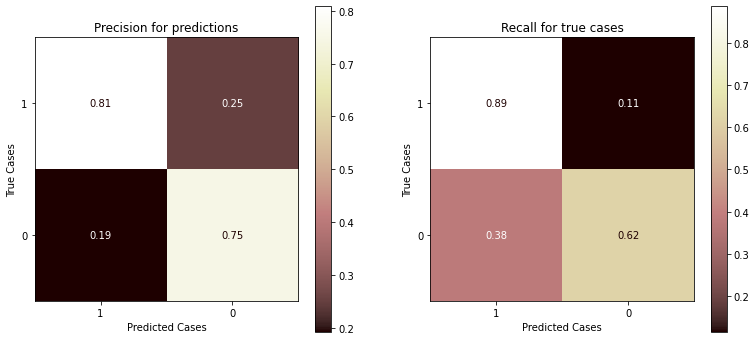

In [19]:
fig, ax = plt.subplots(figsize=(13,6), ncols=2)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='pred', 
                                        display_labels=[1,0],cmap='pink', ax=ax[0])


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true', 
                                        display_labels=[1,0],cmap='pink', ax=ax[1]);

ax[0].set_title("Precision for predictions")
ax[1].set_title("Recall for true cases")

ax[0].set_xlabel('Predicted Cases')
ax[0].set_ylabel('True Cases')
ax[1].set_xlabel('Predicted Cases')
ax[1].set_ylabel('True Cases');

## So far RandomForests and Logistic Regression have similar results, while DecisionTrees are less accurate (might need more tuning)

Will try ensemble methods next
